In [67]:
import pandas as pd
import seaborn as sns
import urllib.request
import gzip
import qgrid
import gffutils
import sqlite3

from itertools import repeat
from scipy.spatial.distance import pdist, cdist

import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# download data here if it doesn't exist already
net_file_path = './dm3.droVir3.net.gz'
net_file_url = 'http://hgdownload.soe.ucsc.edu/goldenPath/dm3/vsDroVir3/dm3.droVir3.net.gz'

if not osp.exists(net_file_path):
    print('downloading synteny file')
    urllib.request.urlretrieve(net_file_url, net_file_path)

In [3]:
# Net File Format Reference: https://genome.ucsc.edu/goldenPath/help/net.html

data = []

def StringIsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False


with gzip.open(net_file_path, 'r') as netfile:
    for i, line in enumerate(netfile):
        fields = line.decode('utf-8').strip().split()
        
        if fields[0] == 'net':
            current_chromosome = fields[1]
            continue
        
        # lines prefixed with 'gap' are not matching
        lineIsNotSynteny = fields[0] != 'fill'
        
        if lineIsNotSynteny:
            continue
    
        # These are attributes that are mandatory and fixed    
        _, tstart, tsize, qname, plusminus, qstart, qsize = fields[:7]
        
        # There are extra attributes that are not always specified/are optional
        optional_attributes = {}


        for optional_attribute_name in fields[7::2]:
            index_of_attribute = fields.index(optional_attribute_name)
            attribute_value = fields[index_of_attribute + 1]
            optional_attributes[optional_attribute_name] = int(attribute_value) \
                                                            if StringIsInt(attribute_value)\
                                                            else attribute_value
        
        attributes_table  = {
                 'melano_chromosome': current_chromosome, 
                 'melano_start': int(tstart),
                 'melano_size': int(tsize),
                 'virilis_chromosome': qname,
                 'relative_orientation': plusminus,
                 'virilis_start': int(qstart),
                 'virilis_size': int(qsize)}
        
        
        attributes_table.update(optional_attributes)
        
        data.append(attributes_table)

        
my_data_frame = pd.DataFrame(data)

In [4]:
qgrid.show_grid(my_data_frame)

In [5]:
syntenic_query = 'melano_size > 10000 and virilis_size > 10000 and type == "syn" '\
                 'and melano_chromosome == "chr2L"'

big_syntenic_blocks = my_data_frame.query(syntenic_query)\
    .sort_values('score', ascending=False)

In [6]:
if not osp.exists('syntenic_blocks.csv'):
    print('saving syntenic blocks to csv')
    big_syntanic_blocks.to_csv('syntenic_blocks.csv')
    

In [7]:
qgrid.show_grid(big_syntenic_blocks)

In [8]:
# long range contact stuff
long_range_contact_url = 'http://www.cell.com/cms/attachment/2007964571/2030739776/mmc3.xls'
long_range_contact_path = './long_range_contacts.xls'

if not osp.exists(long_range_contact_path):
    print('downloading long range contacts')
    urllib.request.urlretrieve(long_range_contact_url, long_range_contact_path)

In [9]:
long_range_contacts = pd.read_excel(long_range_contact_path, header=3)
qgrid.show_grid(long_range_contacts)

In [10]:
# on 2l, the contact points
chromosome_2L_points = long_range_contacts.query('Chr == "2L"')

In [11]:
# looped areas (should count from outside of sticking area)
start_stop_points = ['Xstart', 'Xend', 'Ystart', 'Yend']
forward_loops = chromosome_2L_points['Yend'] - chromosome_2L_points['Xstart']
backward_loops = chromosome_2L_points['Xend'] - chromosome_2L_points['Ystart']

is_forward_loop = forward_loops > 0
is_backward_loop = ~is_forward_loop

loop_lengths = forward_loops * is_forward_loop + backward_loops * is_backward_loop
chromosome_2L_points['loop_length'] = loop_lengths
qgrid.show_grid(chromosome_2L_points)

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
filtered_points = chromosome_2L_points.query('loop_length < 3e6') 
qgrid.show_grid(filtered_points)

num_loops:  30
loop coverage of chromosome 2L: 0.206956521739


/usr/local/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


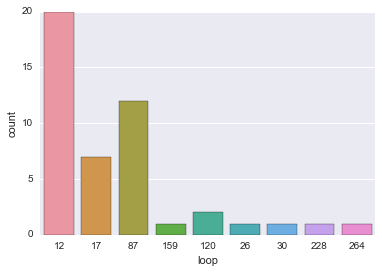

In [13]:
loops = pd.DataFrame()

loops['loop_start'] = filtered_points[start_stop_points].min(axis=1)
loops['loop_stop'] = filtered_points[start_stop_points].max(axis=1)

# def overlap(start1, end1, start2, end2):
#     """Does the range (start1, end1) overlap with (start2, end2)?"""
#     return end1 >= start2 and end2 >= start1

def overlap(a,b,c,d):
    r = 0 if a==c and b==d else min(b,d)-max(a,c)
    if r >= 0: 
        return r
    else:
        return 0

def overlapper(m_start, m_end):
    def overlap_inner(row):
        return overlap(row['loop_start'], row['loop_stop'], m_start, m_end)
    
    return overlap_inner

def array_overlap(segment_a, segment_b):
    return overlap(segment_a[0], segment_a[1], segment_b[0], segment_b[1])
    

blocks = dict(zip(big_syntenic_blocks.index, repeat(None)))
for row in big_syntenic_blocks.itertuples():
    # calculate coverage with loops
    index = row[0]
    melano_size = row[4]
    melano_start = row[5]
    melano_end = melano_start + melano_size
    
    overlap_function = overlapper(melano_start, melano_end)
    
    coverage = loops.apply(overlap_function, axis=1) / melano_size
    
    covering_loop = coverage.argmax()
    
    blocks[index] = covering_loop
    #     print('block {} coverage {} covering loop {}'.format(index, coverage.max(), covering_loop))
    
block_series = pd.Series(blocks)
    
# how many loops are there
num_loops = len(loops)

print('num_loops: ', num_loops)

# how much of this chromosome is covered by loops
# you can calculate this by generating the condensed overlap matrix
all_overlaps = pdist(loops[['loop_start', 'loop_stop']].values, array_overlap).sum()
all_loops = (loops['loop_stop'] - loops['loop_start']).sum()

unique_loop_coverage = all_loops - all_overlaps
unique_loop_ratio = unique_loop_coverage / all_loops

chr_2l_length = 23e6

print('loop coverage of chromosome 2L:', unique_loop_coverage / chr_2l_length)

# what is the distribution of loops covered by each
# print(block_series)
sns.countplot(block_series)
plt.xlabel('loop')

In [14]:
# insulator data
# download from http://gbrowse.modencode.org/fgb2/gbrowse/fly/?label=Insulators_CLASSES_KW for class 1, 2

insulator_file = './Insulators_CLASSES_KW_2L.gff3.txt'

insulator_db_fn = './insulators.db'

if not osp.exists(insulator_db_fn):
    gffutils.create_db(insulator_file, insulator_db_fn)
    

In [50]:
# read insulator db into a pandas frame
with sqlite3.connect(insulator_db_fn) as connection:
    insulator_df = pd.read_sql_query("SELECT * from features", connection)
    insulator_df.drop(['score', 'strand', 'frame', 'extra'], axis=1, inplace=True)

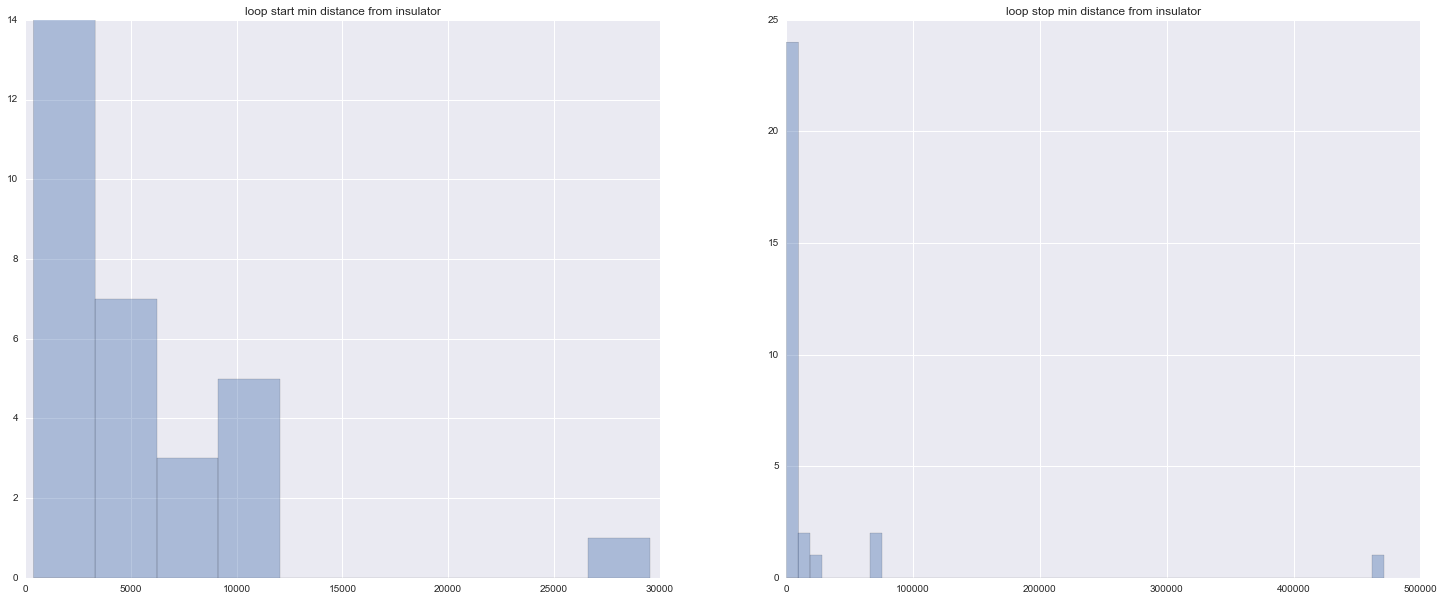

In [92]:
# we want to see that insulators appear near to the loop boundaries
loop_endpoints = np.atleast_2d(np.hstack((loops.loop_start.values, loops.loop_stop.values))).T

loop_starts = np.atleast_2d(loops.loop_start.values).T
loop_stops = np.atleast_2d(loops.loop_stop.values).T

# they put all the insulators on the + strand so the endpoint is strictly after the start
insulator_midpoints = np.atleast_2d((insulator_df.start + (insulator_df.start - insulator_df.end) / 2).values).T

insulator_loop_start_distance = (cdist(loop_starts, insulator_midpoints, 'cityblock'))
insulator_loop_stop_distance = (cdist(loop_stops, insulator_midpoints, 'cityblock'))

insulator_loop_start_min = insulator_loop_start_distance.min(axis=1)
insulator_loop_stop_min = insulator_loop_stop_distance.min(axis=1)

plt.figure(figsize=(25, 10))
plt.subplot(121)

plt.title('loop start min distance from insulator')
sns.distplot(insulator_loop_start_min, kde=False)

plt.subplot(122)

plt.title('loop stop min distance from insulator')
sns.distplot(insulator_loop_stop_min, kde=False)

# insulator_loop_end_distance_min = insulator_loop_end_distance.min(axis=1)

# sns.distplot(insulator_loop_end_distance_min, kde=False)

print('loop end insulator min distance')
print(pd.Series(insulator_loop_stop_min).describe())

print('loop start insulator min distance')
print(chr_2l_length)